In [1]:
import glob
import os
import librosa
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
%matplotlib inline
plt.style.use('ggplot')


In [2]:
def windows(data, window_size):
    start = 0
    while start < len(data):
        yield int(start), int(start + window_size)
        start += (window_size / 2)
        
def extract_features(parent_dir,sub_dir,file_ext="*.wav",bands = 60, frames = 41):
    window_size = 512 * (frames - 1)
    log_specgrams = []
    labels = []
    
    for fn in glob.glob(os.path.join(parent_dir, sub_dir, file_ext)):
        sound_clip,s = librosa.load(fn)
        label = fn.split('/')[-1][-5]
        
        for (start,end) in windows(sound_clip,window_size):
            if(len(sound_clip[start:end]) == window_size):
                signal = sound_clip[start:end]
                melspec = librosa.feature.melspectrogram(signal, n_mels = bands)
                logspec = librosa.logamplitude(melspec)
                logspec = logspec.T.flatten()[:, np.newaxis].T
                log_specgrams.append(logspec)
                labels.append(label)
            
    log_specgrams = np.asarray(log_specgrams).reshape(len(log_specgrams),bands,frames,1)
    features = np.concatenate((log_specgrams, np.zeros(np.shape(log_specgrams))), axis = 3)
    
    for i in range(len(features)):
        features[i, :, :, 1] = librosa.feature.delta(features[i, :, :, 0])
    
    return np.array(features), np.array(labels,dtype = np.int)


def one_hot_encode(labels):
    n_labels = len(labels)
    n_unique_labels = len(np.unique(labels))
    one_hot_encode = np.zeros((n_labels,n_unique_labels))
    one_hot_encode[np.arange(n_labels), labels] = 1
    return one_hot_encode

In [3]:
parent_dir = "./"
tr_sub_dirs = "Train"

tr_features,tr_labels = extract_features(parent_dir,tr_sub_dirs)
tr_labels = one_hot_encode(tr_labels)

ts_sub_dirs= "Test"
ts_features,ts_labels = extract_features(parent_dir,ts_sub_dirs)
ts_labels = one_hot_encode(ts_labels)


/anaconda/lib/python2.7/site-packages/resampy/core.py:90: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(x.dtype, np.float):


In [14]:
frames = 41
bands = 60

feature_size = 2460 #60x41
num_labels = 10
num_channels = 2

batch_size = 50
kernel_size = 30
depth = 20
num_hidden = 200

learning_rate = 0.01
total_iterations = 2000

In [15]:
###1. placeholders for data (x) and labels (y)
x = tf.placeholder(tf.float32, shape=[None,bands,frames,num_channels])
y = tf.placeholder(tf.float32, shape=[None,num_labels])

x_input =x

#######################
### 2.define layers ###
# 20 30x30 filters with stride of 1, ReLU activation
conv1 = tf.layers.conv2d(inputs=x_input, filters=20, kernel_size=[30,20], activation=tf.nn.relu)

# 20x20 max pooling with stride of 2
pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2,2], strides=[2,2])

# second convolutional layer
conv2 = tf.layers.conv2d(inputs=pool1, filters=32, kernel_size=[6,4], activation=tf.nn.relu)

# second pooling layer
pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2,2], strides=[2,2])

# flatten the final feature maps
flat = tf.layers.flatten(pool2)

# pass flattened input into the first fully connected layer
fc1 = tf.layers.dense(inputs=flat, units=512, activation=tf.nn.relu)

# use dropout to generalize the model
dropout = tf.layers.dropout(inputs=fc1)

# define second fully connected layer for 0-9 classification
y_pred = tf.layers.dense(inputs=fc1, units=10) 

# output probabilities of input slip belonging to each class
probabilities = tf.nn.softmax(y_pred)


In [16]:
#####################################
###3. loss function and accuracy ####
# calculate mean cross entropy over entire batch of samples. 
import tensorflow as tf

cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y, logits=y_pred))

optimizer = tf.train.AdamOptimizer(1e-3).minimize(cross_entropy)
correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

100%|██████████| 2000/2000 [07:20<00:00,  4.54it/s]


('Test accuracy: ', 0.461)


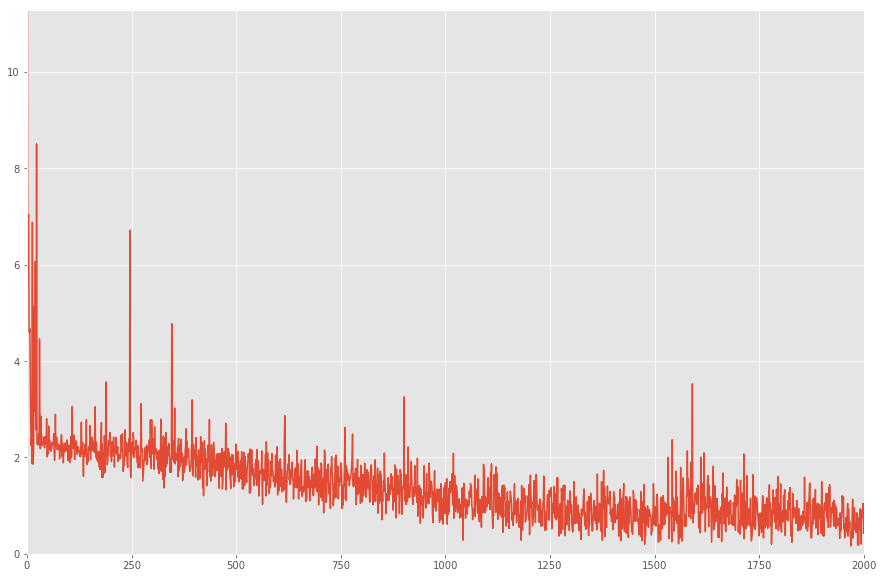

In [17]:
import tqdm

cost_history = np.empty(shape=[1],dtype=float)

with tf.Session() as session:
    tf.initialize_all_variables().run()
    summary_writer = tf.summary.FileWriter("./logs", graph=tf.get_default_graph())

    for itr in tqdm.tqdm(range(total_iterations)):   
        offset = (itr * batch_size) % (tr_labels.shape[0] - batch_size)
        batch_x = tr_features[offset:(offset + batch_size), :, :, :]
        batch_y = tr_labels[offset:(offset + batch_size), :]
        
        _, c = session.run([optimizer, cross_entropy],feed_dict={x: batch_x, y : batch_y})
        cost_history = np.append(cost_history,c)
    
    print('Test accuracy: ',round(session.run(accuracy, feed_dict={x: ts_features, y: ts_labels}) , 3))
    
    # now plotting the variation of training performance
    fig = plt.figure(figsize=(15,10))
    plt.plot(cost_history)
    plt.axis([0,total_iterations,0,np.max(cost_history)])
    plt.show()